In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from lightgbm import LGBMClassifier

In [6]:
df = pd.read_csv('emails.csv')
df = df.set_index('Email No.')
df.head()

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
Email No.,,,,,,,,,,,,,,,,,,,,,
Email 1,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Email 2,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,1,0,0
Email 3,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
Email 4,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
Email 5,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,1,0,0


In [14]:
df.info()

the           int64
to            int64
ect           int64
and           int64
for           int64
              ...  
military      int64
allowing      int64
ff            int64
dry           int64
Prediction    int64
Length: 3001, dtype: object

In [8]:
X = df.drop('Prediction', axis=1)
y = pd.DataFrame(df['Prediction'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
model = LGBMClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_valid)

print(f'accuracy_score: {accuracy_score(y_valid, preds)}')

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1059, number of negative: 2561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19779
[LightGBM] [Info] Number of data points in the train set: 3620, number of used features: 2441
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292541 -> initscore=-0.883073
[LightGBM] [Info] Start training from score -0.883073
accuracy_score: 0.9768041237113402


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1111
           1       0.95      0.97      0.96       441

    accuracy                           0.98      1552
   macro avg       0.97      0.97      0.97      1552
weighted avg       0.98      0.98      0.98      1552



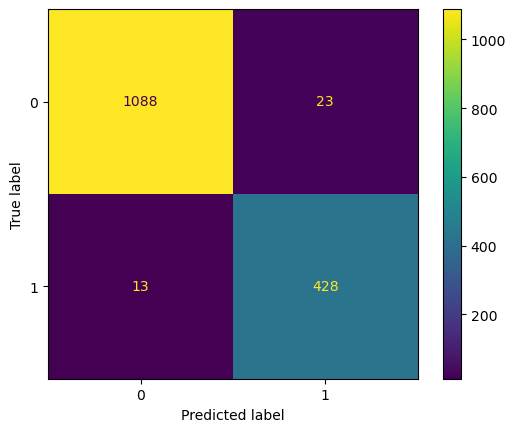

In [10]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_valid, preds))

In [ ]:
from pydantic import BaseModel, ValidationError

class Email(BaseModel):
    the: int